# Questions by Daniel Majer

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import Callable

tidy_data: pd.DataFrame = pd.read_csv('./data/tidy_seer_breast_cancer_dataset.csv')

### Question 1.1
- What's the range of ages in each race group, when most probable that women can be affected by breast cancer based on this data set?

1. Get the ages for each groups.

2. Display grouped ages as a boxplot we can visualize the spread of the ages and getting the values for the interquartiles.

3. After that, rearrange the obtained datas and display them as a histogram for easier interpretation.


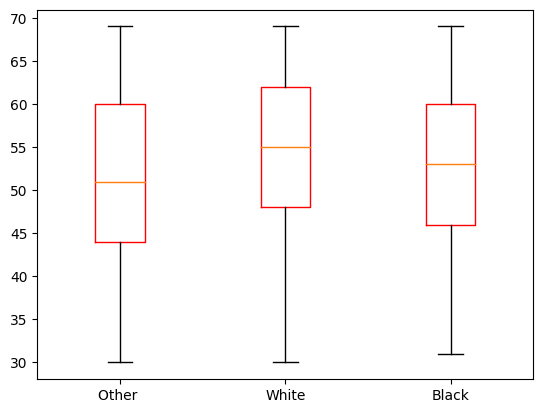

In [2]:
def get_age_series_by_race(tidy_data: pd.DataFrame) -> tuple[list[str], list[pd.Series]]:
    '''Create list of series for each race with the age values.
    '''
    races_ls: list[pd.Series] = []
    races_labels: list[str]   = []
    for race in tidy_data['race'].unique():
        races_ls.append(tidy_data.loc[(tidy_data['race'] == race)]['age'])
        races_labels.append(race)

    return races_ls, races_labels

def get_age_interquartile(tidy_data: pd.DataFrame, labels: list[str], bp: list[dict[str, float]]) -> pd.DataFrame:
    ''' Get interquartile values of each box in the plot 
        and fetch them into a data frame as it can be plotted in a histogram.
    '''

    tmp_dict: dict[str, list[int]] = {}

    for i in range(len(labels)):
        
        tmp_dict.setdefault(labels[i], [])

        lower_quartile: float = bp['boxes'][i].get_ydata()[1]
        upper_quartile: float = bp['boxes'][i].get_ydata()[2]
        
        race_ages:          pd.DataFrame = tidy_data.loc[(tidy_data['race'] == labels[i])]
        most_affected_ages: list[int]    = list(race_ages[race_ages['age'].between(lower_quartile, upper_quartile)]['age'])
        
        tmp_dict[labels[i]] += most_affected_ages
        
    df_dict = {'race': [], 'age': []}

    for race, ages in tmp_dict.items():
        df_dict['race'] += [race.strip(' ') for _ in range(len(ages))]
        df_dict['age']  += ages

    return pd.DataFrame(df_dict)


# BOXPLOT
races_ls, races_labels = get_age_series_by_race(tidy_data)
boxplt_ages_by_races: dict[str, dict | list] = plt.boxplot(
                                                    races_ls, 
                                                    boxprops=dict(color='red'),
                                                    labels=races_labels
)

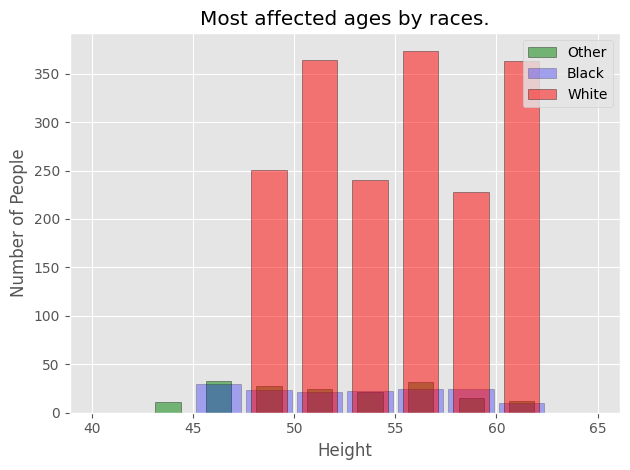

In [3]:
# BAR PLOT
boxplt_interquartiles: pd.DataFrame = get_age_interquartile(tidy_data, 
                                                            races_labels, 
                                                            boxplt_ages_by_races
                                      )

plt.style.use('ggplot')
plt.title('Most affected ages by races.')

# OTHER
plt.hist(boxplt_interquartiles.loc[(boxplt_interquartiles['race'] == 'Other')]['age'], 
                                    rwidth = 0.5, 
                                    alpha = 0.5, 
                                    edgecolor='black',
                                    color='green',
                                    bins=10, 
                                    label='Other',
                                    range=[40,65]
)

# BLACK
plt.hist(boxplt_interquartiles.loc[(boxplt_interquartiles['race'] == 'Black')]['age'],
                                    rwidth = 0.9,
                                    alpha = 0.3,
                                    edgecolor='black',
                                    color='blue',
                                    bins=10,
                                    label='Black',
                                    range=[40,65]
)

# OTHER
plt.hist(boxplt_interquartiles.loc[(boxplt_interquartiles['race'] == 'White')]['age'], 
                                    rwidth = 0.7,
                                    alpha = 0.5,
                                    edgecolor='black',
                                    color='red',
                                    bins=10,
                                    label='White',
                                    range=[40,65]
)

plt.legend(loc='upper right')
plt.xlabel('Height')
plt.ylabel('Number of People')
plt.tight_layout()
plt.show()

### 1.2 Gráfico de Barras con Normalización
In those ages which suffer the most from breast cancer, what are the frequencies of the 6th stage categories?

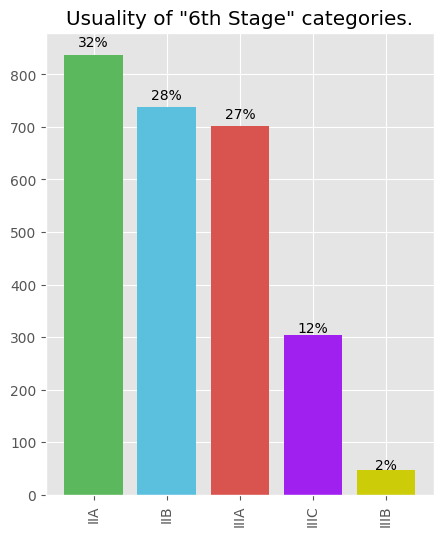

In [4]:
ages: list[int] = set(boxplt_interquartiles.loc[:, 'age'])
min_age:    int = min(ages)
max_age:    int = max(ages)

# Filter for the obtained range, 
# and remove the "Unnamed" column left behind from a previous index column.
most_affected_pacients: pd.DataFrame = (
            tidy_data[tidy_data['age'].between(min_age, max_age)]
                                      .loc[:, ~tidy_data.columns.str.contains('^Unnamed')]
)

# status: What's the ratio of survival corresponding to these datas.
frequencies: int = most_affected_pacients['6th_stage'].value_counts()
total_cases: int = frequencies.sum()

# fig, ax = plt.subplots()
colors_list = ['#5cb85c', 
               '#5bc0de',
               '#d9534f', 
               '#A020F0',
               '#CCCC09'
            ]

ax = (most_affected_pacients['6th_stage'].value_counts()
                                        .plot(kind      = 'bar',
                                              width     = 0.8,
                                              figsize   = (5,6),
                                              color     = colors_list,
                                              edgecolor = None
                                        )
)

ax.set_title('Usuality of "6th Stage" categories.')

# Add the annotations
for p in ax.patches:

    width:  np.float64 = p.get_width()
    height: np.float64 = p.get_height()

    x, y = p.get_xy()

    ax.annotate(f'{(height / total_cases):.0%}', 
                (x + width/2, y + height*1.02), 
                ha='center'
    )


### 2. Scatter plots y rectas de regresión

    Still using the age range of the most effected echelon by the breast cancer,
    as a rough estimation, how the survival rate is affected by the age?

1. First We need to use a more regular value unit, such as percentage (the most common) to represent the survival rate for each age.

2. Create a scatter plot for the obtained rates.

3. Calculate and fetch the regression line onto the previous scatter plot.

/home/dama/venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


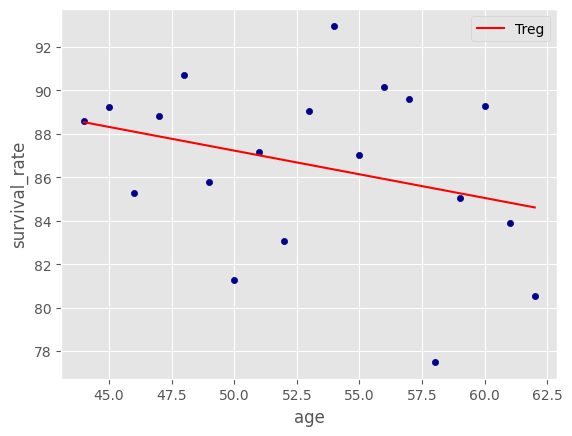

In [10]:
total_by_age: pd.DataFrame = (most_affected_pacients.groupby('age', as_index=True)
                                                    .agg(total = ('status', 'count'))
)

survival_rates: pd.DataFrame = (most_affected_pacients.loc[(most_affected_pacients['status'] == 'Alive')]
                                                      .groupby('age', as_index=True)
                                                      .agg(survivals = ('status', 'count'))
)

merged_df = pd.concat([survival_rates, total_by_age], axis=1, join="inner")

merged_df['survival_rate'] = (merged_df['survivals'] / merged_df['total']) * 100
merged_df.drop(columns=['survivals', 'total'], inplace=True)

merged_df = merged_df.reset_index()

ax = merged_df.plot.scatter(x='age', y='survival_rate', c = 'DarkBlue')

g = np.polyfit(merged_df['age'], merged_df['survival_rate'],1)
f = np.poly1d(g)

merged_df.insert(2, 'Treg', f(merged_df['age']))
_  = merged_df.plot(x='age', y='Treg', color='Red', ax=ax)

### 3. Boxplot

    Visualizing on a similar way as in the previous question, how the survival rate is affected by longer having the cancer present in the host's body?

mortalidad y supervivencia basado en el número de meses que ha estado el tumor dentro del cuerpo.
sns.boxplot('Survival Months', 'Status', data=df)

Conclusión
tiendes a pensar que mientras más tiempo está el tumor en tu cuerpo menos probabilidades de vivir tienes, pero es al revés.
